In [1]:
#import all necessary pakages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset




Here we have car sales dataset from 2005 to 2024

In [3]:
df=pd.read_csv('/car_sales_M.csv')
df

,Date,Car_Sales
0,2005-01-31,311.67
1,2005-02-28,379.75
2,2005-03-31,438.01
3,2005-04-30,444.12
4,2005-05-31,348.74
...,...,...
227,2023-12-31,4013.53
228,2024-01-31,4177.92
229,2024-02-29,4331.25
230,2024-03-31,4386.71


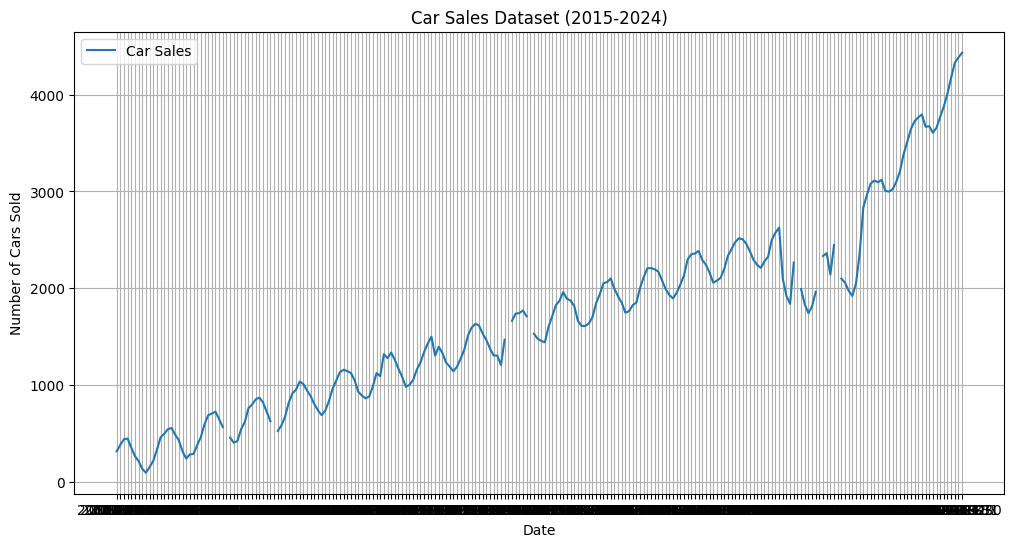

In [4]:
# Plot to visualize
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Car_Sales'], label='Car Sales')
plt.title('Car Sales Dataset (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Number of Cars Sold')
plt.grid(True)
plt.legend()
plt.show()

here in this plot some intervel of points is breaked in between due to presence of some null values

In [5]:
print(df.isnull().sum())

Date         0
Car_Sales    7
dtype: int64


In [6]:
# Impute missing values using forward fill
df['Car_Sales'] = df['Car_Sales'].fillna(method='ffill')
print(df.isnull().sum())

Date         0
Car_Sales    0
dtype: int64


<ipython-input-6-82d9931f1338>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Car_Sales'] = df['Car_Sales'].fillna(method='ffill')


In [7]:
df.describe()

,Car_Sales
count,232.000000
mean,1672.452974
std,954.377724
min,91.050000
25%,925.100000
50%,1649.110000
75%,2200.212500
max,4435.390000


<Axes: >

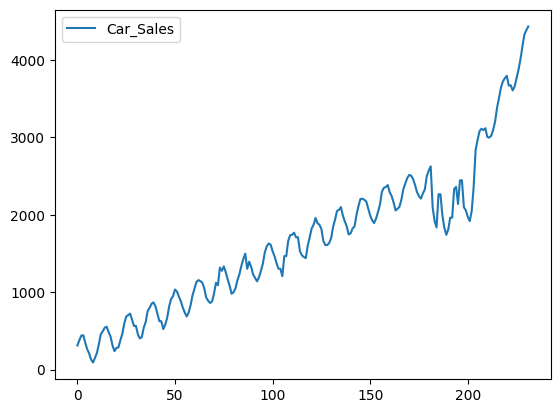

In [8]:
df.plot()

Checking for Stationarity
There are 2 statistical tests to check the time series data is stationary or not.

1- ADF - Augmented Dickey-Fuller Test
2- Detrending/Differencing

Conducting ADF Test
We will contuct ADF test with the following assumptions and hypotheses:

Null Hypothesis (H0): Data is not stationary.
Alternative Hypothesis (H1): Data is stationary.

In [9]:
adfuller(df['Car_Sales'])

(0.8698300109668128,
 0.9926836941751156,
 15,
 216,
 {'1%': -3.4609922013325267,
  '5%': -2.875015740963014,
  '10%': -2.5739524288408777},
 2579.1535025349635)

In [10]:
def adfuller_test(sales):
    result = adfuller(sales)

    labels = ['ADF test statistics', 'p-value', 'Lags used', 'Number of obs used']

    for value, label in zip(result, labels):
        print('{} : {} '.format(label, value))

    if result[1]<=0.05:
        print('Strong evidence against null hypothesis, reject the null hypothesis and data is stationary')
    else:
        print('Weak evidence against null hypothesis, accept the null hypothesis and data is not stationary')

In [11]:
adfuller_test(df['Car_Sales'])

ADF test statistics : 0.8698300109668128 
p-value : 0.9926836941751156 
Lags used : 15 
Number of obs used : 216 
Weak evidence against null hypothesis, accept the null hypothesis and data is not stationary


As seen above, the p-value of the ADF test is greater than 0.05, so our data is not stationary. For time series use case we have to make our data stationary.

In [12]:
df['Car_Sales'].shift(1)
df['Car_Sales first diff.'] = df['Car_Sales'] - df['Car_Sales'].shift(1)
df.head()

,Date,Car_Sales,Car_Sales first diff.
0,2005-01-31,311.67,NaN
1,2005-02-28,379.75,68.08
2,2005-03-31,438.01,58.26
3,2005-04-30,444.12,6.11
4,2005-05-31,348.74,-95.38


In [13]:
df['Seasonal first diff.'] = df['Car_Sales'] - df['Car_Sales'].shift(12)
df.head()

,Date,Car_Sales,Car_Sales first diff.,Seasonal first diff.
0,2005-01-31,311.67,NaN,NaN
1,2005-02-28,379.75,68.08,NaN
2,2005-03-31,438.01,58.26,NaN
3,2005-04-30,444.12,6.11,NaN
4,2005-05-31,348.74,-95.38,NaN


In [14]:
adfuller_test(df['Seasonal first diff.'].dropna())

ADF test statistics : -2.199615960197418 
p-value : 0.20638487067606814 
Lags used : 12 
Number of obs used : 207 
Weak evidence against null hypothesis, accept the null hypothesis and data is not stationary




already applied first differencing and seasonal differencing, but the data still seems to be non-stationary. so next try to apply second differencing.

In [15]:
df['Seasonal Second diff'] = df['Car_Sales'].diff().diff().dropna()
adfuller_test(df['Seasonal Second diff'].dropna())

ADF test statistics : -9.339939231958553 
p-value : 8.852661698648275e-16 
Lags used : 14 
Number of obs used : 215 
Strong evidence against null hypothesis, reject the null hypothesis and data is stationary


In [16]:
df

,Date,Car_Sales,Car_Sales first diff.,Seasonal first diff.,Seasonal Second diff
0,2005-01-31,311.67,NaN,NaN,NaN
1,2005-02-28,379.75,68.08,NaN,NaN
2,2005-03-31,438.01,58.26,NaN,-9.82
3,2005-04-30,444.12,6.11,NaN,-52.15
4,2005-05-31,348.74,-95.38,NaN,-101.49
...,...,...,...,...,...
227,2023-12-31,4013.53,134.30,628.18,27.63
228,2024-01-31,4177.92,164.39,666.06,30.09
229,2024-02-29,4331.25,153.33,685.03,-11.06
230,2024-03-31,4386.71,55.46,660.06,-97.87


<Axes: >

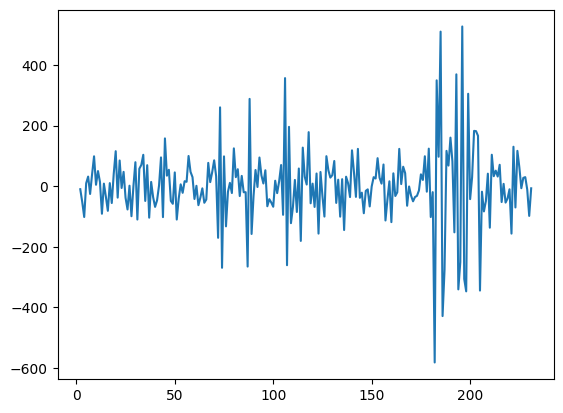

In [17]:
df['Seasonal Second diff'].plot()

ARIMA

ARIMA is an acronym for “autoregressive integrated moving average.” It's a model used in statistics and econometrics to measure events that happen over a period of time. The model is used to understand past data or predict future data in a series.

In [18]:
df.head(15)

,Date,Car_Sales,Car_Sales first diff.,Seasonal first diff.,Seasonal Second diff
0,2005-01-31,311.67,NaN,NaN,NaN
1,2005-02-28,379.75,68.08,NaN,NaN
2,2005-03-31,438.01,58.26,NaN,-9.82
3,2005-04-30,444.12,6.11,NaN,-52.15
4,2005-05-31,348.74,-95.38,NaN,-101.49
5,2005-06-30,263.24,-85.50,NaN,9.88
6,2005-07-31,209.64,-53.60,NaN,31.90
7,2005-08-31,130.59,-79.05,NaN,-25.45
8,2005-09-30,91.05,-39.54,NaN,39.51
9,2005-10-31,150.33,59.28,NaN,98.82


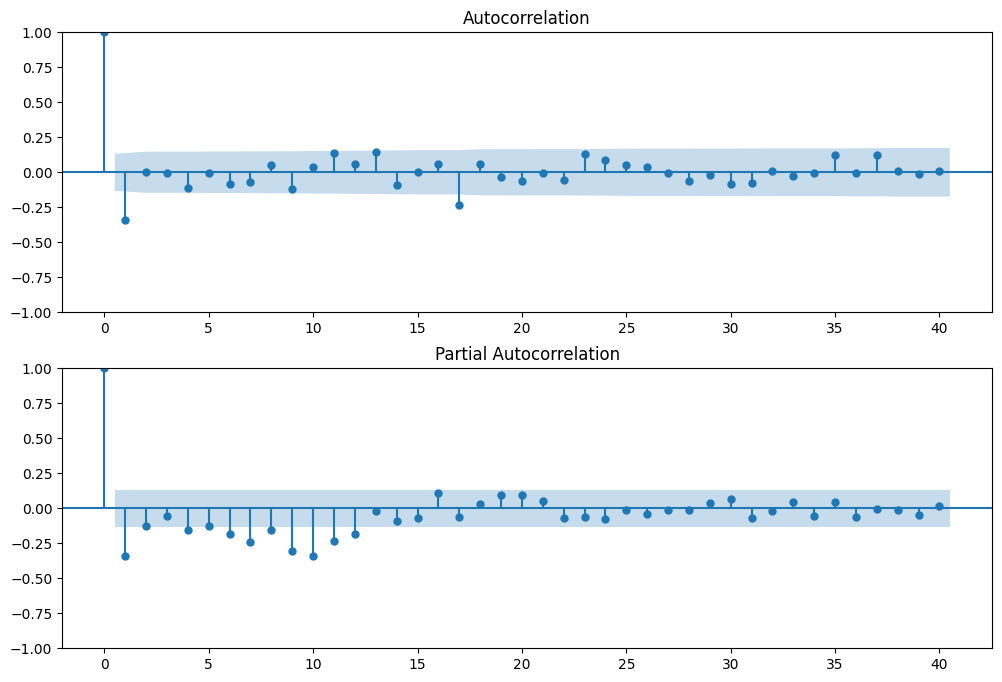

In [19]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal Second diff'].iloc[13:], lags=40, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal Second diff'].iloc[13:], lags=40, ax=ax2)

In [20]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Car_Sales'], order=(1,1,1))

In [21]:
model = model.fit()

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Car_Sales   No. Observations:                  232
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1401.275
Date:                Mon, 12 Aug 2024   AIC                           2808.550
Time:                        18:15:23   BIC                           2818.878
Sample:                             0   HQIC                          2812.716
                                - 232                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4241      0.128      3.321      0.001       0.174       0.674
ma.L1         -0.0537      0.126     -0.428      0.669      -0.300       0.192
sigma2      1.087e+04    542.465     20.038      0.000    9806.935    1.19e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               387.52
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               4.43   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
df['forecast'] = model.predict(start=90, end=103, dynamic=True)

In [24]:
df.tail(20)

,Date,Car_Sales,Car_Sales first diff.,Seasonal first diff.,Seasonal Second diff,forecast
212,2022-09-30,3023.04,24.42,1049.42,33.09,NaN
213,2022-10-31,3098.89,75.85,1179.50,51.43,NaN
214,2022-11-30,3206.72,107.83,1158.82,31.98,NaN
215,2022-12-31,3385.35,178.63,1027.19,70.80,NaN
216,2023-01-31,3511.86,126.51,677.01,-52.12,NaN
217,2023-02-28,3646.22,134.36,678.93,7.85,NaN
218,2023-03-31,3726.65,80.43,644.91,-53.93,NaN
219,2023-04-30,3766.71,40.06,653.53,-40.37,NaN
220,2023-05-31,3796.73,30.02,700.91,-10.04,NaN
221,2023-06-30,3670.45,-126.28,550.52,-156.30,NaN


<Axes: >

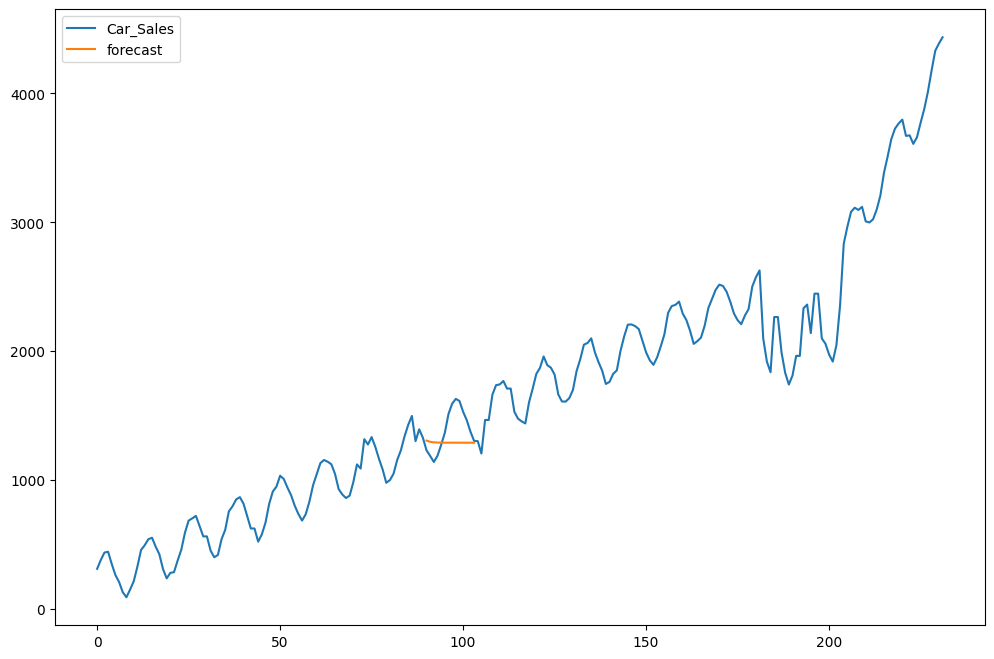

In [25]:
df[['Car_Sales', 'forecast']].plot(figsize=(12,8))

As seen above, ARIMA did not predict better. The reason behind this is when we have seasonal data ARIMA is not suitable. We will use SARIMAX which is Seasonal ARIMA, it is an extension of ARIMA

SARIMAX

SARIMAX is used on data sets that have seasonal cycles. The difference between ARIMA and SARIMAX is the seasonality and exogenous factors (seasonality and regular ARIMA don't mix well

In [26]:
model = sm.tsa.statespace.SARIMAX(df['Car_Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))

In [27]:
results = model.fit()

In [28]:
df['forecast_SARIMAX'] = results.predict(start=90, end=103, dynamic=True)

In [29]:
df.tail(20)

,Date,Car_Sales,Car_Sales first diff.,Seasonal first diff.,Seasonal Second diff,forecast,forecast_SARIMAX
212,2022-09-30,3023.04,24.42,1049.42,33.09,NaN,NaN
213,2022-10-31,3098.89,75.85,1179.50,51.43,NaN,NaN
214,2022-11-30,3206.72,107.83,1158.82,31.98,NaN,NaN
215,2022-12-31,3385.35,178.63,1027.19,70.80,NaN,NaN
216,2023-01-31,3511.86,126.51,677.01,-52.12,NaN,NaN
217,2023-02-28,3646.22,134.36,678.93,7.85,NaN,NaN
218,2023-03-31,3726.65,80.43,644.91,-53.93,NaN,NaN
219,2023-04-30,3766.71,40.06,653.53,-40.37,NaN,NaN
220,2023-05-31,3796.73,30.02,700.91,-10.04,NaN,NaN
221,2023-06-30,3670.45,-126.28,550.52,-156.30,NaN,NaN


<Axes: >

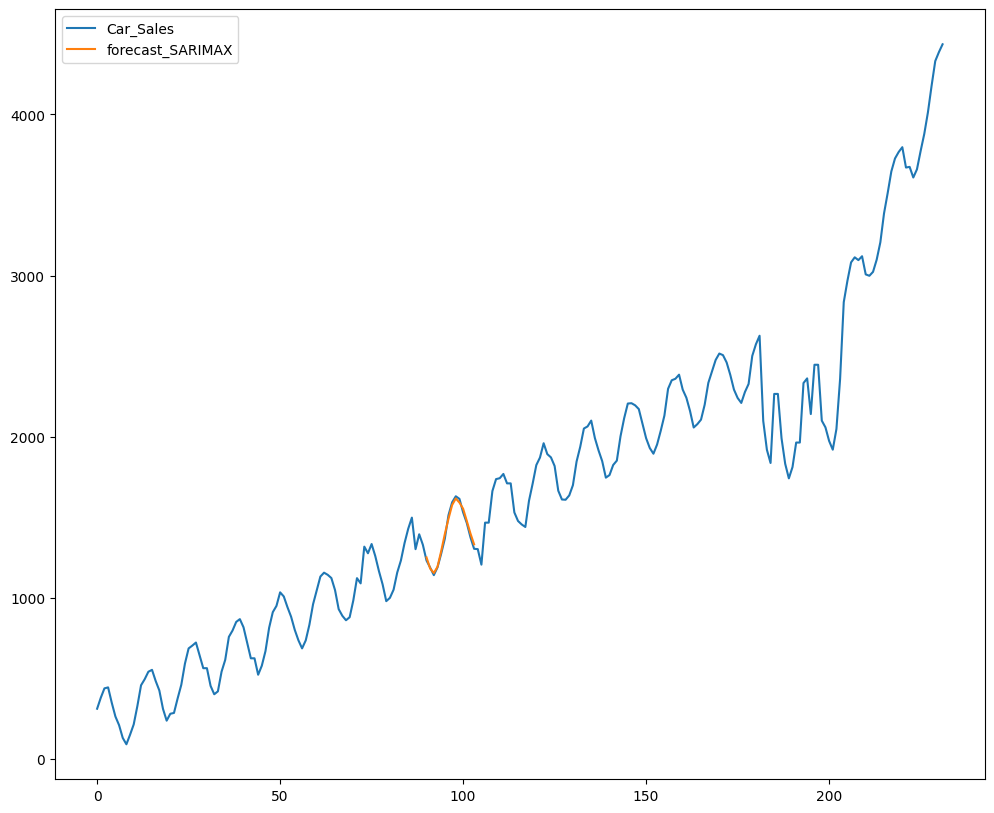

In [30]:
df[['Car_Sales','forecast_SARIMAX']].plot(figsize=(12,10))

As seen above with the plot, SARIMAX was way better and closer to reality than ARIMA to predict sales


Making Predictions on Future Data with SARIMAX

In [31]:
df['Date'] = pd.to_datetime(df['Date']) # Convert the 'Date' column to datetime
df.set_index('Date', inplace=True) # Set the 'Date' column as the index

In [32]:
future_dates = [df.index[-1] + DateOffset(months=x)for x in range(0,24)]
future_dates[1:]

[Timestamp('2024-05-30 00:00:00'),
 Timestamp('2024-06-30 00:00:00'),
 Timestamp('2024-07-30 00:00:00'),
 Timestamp('2024-08-30 00:00:00'),
 Timestamp('2024-09-30 00:00:00'),
 Timestamp('2024-10-30 00:00:00'),
 Timestamp('2024-11-30 00:00:00'),
 Timestamp('2024-12-30 00:00:00'),
 Timestamp('2025-01-30 00:00:00'),
 Timestamp('2025-02-28 00:00:00'),
 Timestamp('2025-03-30 00:00:00'),
 Timestamp('2025-04-30 00:00:00'),
 Timestamp('2025-05-30 00:00:00'),
 Timestamp('2025-06-30 00:00:00'),
 Timestamp('2025-07-30 00:00:00'),
 Timestamp('2025-08-30 00:00:00'),
 Timestamp('2025-09-30 00:00:00'),
 Timestamp('2025-10-30 00:00:00'),
 Timestamp('2025-11-30 00:00:00'),
 Timestamp('2025-12-30 00:00:00'),
 Timestamp('2026-01-30 00:00:00'),
 Timestamp('2026-02-28 00:00:00'),
 Timestamp('2026-03-30 00:00:00')]

In [33]:
future_dataset = pd.DataFrame(index = future_dates[1:], columns = df.columns)

In [34]:
future_dataset.tail()

,Car_Sales,Car_Sales first diff.,Seasonal first diff.,Seasonal Second diff,forecast,forecast_SARIMAX
2025-11-30,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-30,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-30,NaN,NaN,NaN,NaN,NaN,NaN
2026-02-28,NaN,NaN,NaN,NaN,NaN,NaN
2026-03-30,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
future_df = pd.concat([df, future_dataset])

<ipython-input-35-0e7ad8f522cc>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df = pd.concat([df, future_dataset])


In [36]:
future_df.shape

(255, 6)

In [37]:
future_df['forecast_SARIMAX2'] = results.predict(start=104, end=124, dynamic=True)

<Axes: >

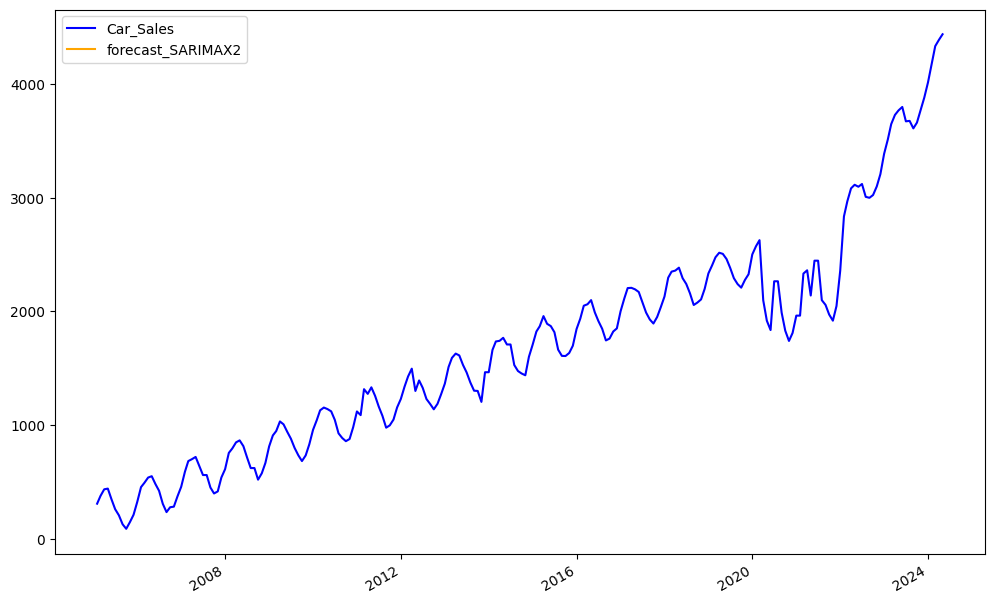

In [38]:
future_df[['Car_Sales', 'forecast_SARIMAX2']].plot(figsize=(12, 8), color=['blue', 'orange'])

In [39]:
print(future_df.index)

DatetimeIndex(['2005-01-31', '2005-02-28', '2005-03-31', '2005-04-30',
               '2005-05-31', '2005-06-30', '2005-07-31', '2005-08-31',
               '2005-09-30', '2005-10-31',
               ...
               '2025-06-30', '2025-07-30', '2025-08-30', '2025-09-30',
               '2025-10-30', '2025-11-30', '2025-12-30', '2026-01-30',
               '2026-02-28', '2026-03-30'],
              dtype='datetime64[ns]', length=255, freq=None)


In [40]:
print(future_df.index[-10:])  # Check the last few dates

DatetimeIndex(['2025-06-30', '2025-07-30', '2025-08-30', '2025-09-30',
               '2025-10-30', '2025-11-30', '2025-12-30', '2026-01-30',
               '2026-02-28', '2026-03-30'],
              dtype='datetime64[ns]', freq=None)


In [41]:
# Fit the SARIMAX model
model = sm.tsa.statespace.SARIMAX(df['Car_Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

# Determine the number of steps to forecast
# Calculate the number of months from the last date in your dataset to March 2026
last_date = df.index[-1]
forecast_end_date = pd.Timestamp('2026-03-31')

num_steps = (forecast_end_date.year - last_date.year) * 12 + forecast_end_date.month - last_date.month

# Generate forecast
forecast = results.get_forecast(steps=num_steps)
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=num_steps, freq='M')
forecast_df = pd.DataFrame(index=forecast_index, columns=['forecast'])

forecast_df['forecast'] = forecast.predicted_mean

# Print forecast values
print(forecast_df)

# Extract the forecast for March 2026
march_2026_forecast = forecast_df.loc['2026-03-31', 'forecast']
print(f"Forecast for March 2026: {march_2026_forecast}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


               forecast
2024-05-31  4411.234979
2024-06-30  4367.160562
2024-07-31  4277.606109
2024-08-31  4202.159867
2024-09-30  4183.263750
2024-10-31  4211.740453
2024-11-30  4314.540895
2024-12-31  4441.075120
2025-01-31  4571.319823
2025-02-28  4674.856885
2025-03-31  4692.058026
2025-04-30  4673.244020
2025-05-31  4645.897629
2025-06-30  4606.514484
2025-07-31  4511.660362
2025-08-31  4435.979123
2025-09-30  4413.069472
2025-10-31  4437.274120
2025-11-30  4539.602360
2025-12-31  4665.981363
2026-01-31  4794.136561
2026-02-28  4895.257622
2026-03-31  4910.155070
Forecast for March 2026: 4910.155070416617


Time Series Forecasting with LSTMs

In [42]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [43]:
df_lstm = pd.read_csv('/car_sales_M.csv',index_col=0,parse_dates=True)
len(df_lstm)

232

In [44]:
df_lstm.dropna(inplace=True)
len(df_lstm)

225

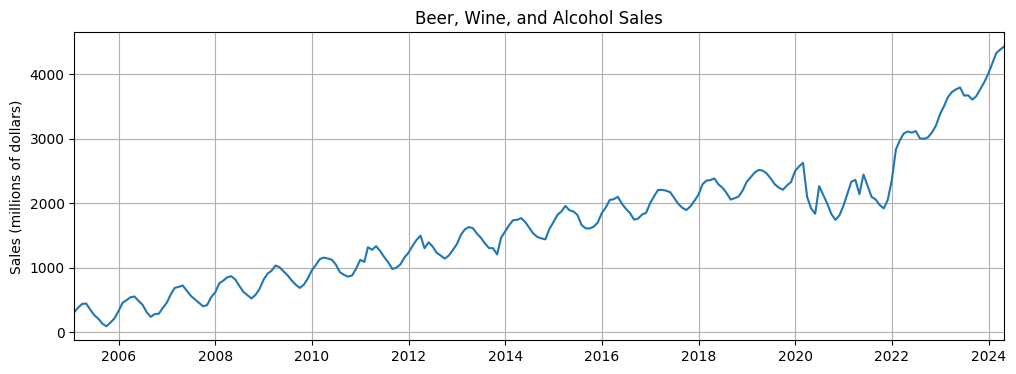

In [45]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df_lstm['Car_Sales'])
plt.show()

In [46]:
y = df_lstm['Car_Sales'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [47]:
print(f"shape of train_set : {train_set.shape}")
print(f"shape of test_set : {test_set.shape}")

shape of train_set : (213,)
shape of test_set : (12,)


In [48]:
#normalize
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [49]:
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [50]:
train_norm[:10]

array([[-0.87995625],
       [-0.84291257],
       [-0.81121214],
       [-0.80788756],
       [-0.85978573],
       [-0.90630798],
       [-0.93547281],
       [-0.9784855 ],
       [-1.        ],
       [-0.96774457]])

Data preparation for LSTM training

Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((232 - test_size) - window_size).

In [51]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq, ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 232-12-12

201

In [52]:
train_data[:2]

[(tensor([-0.8800, -0.8429, -0.8112, -0.8079, -0.8598, -0.9063, -0.9355, -0.9785,
          -1.0000, -0.9677, -0.9328, -0.8707]),
  tensor([-0.8008])),
 (tensor([-0.8429, -0.8112, -0.8079, -0.8598, -0.9063, -0.9355, -0.9785, -1.0000,
          -0.9677, -0.9328, -0.8707, -0.8008]),
  tensor([-0.7803]))]

Define the model

We will be using an LSTM layer of size (1, 100).

In [53]:
class SalesPredictor(nn.Module):

    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                       torch.zeros(1, 1, self.hidden_size))
    def forward(self, seq):
        out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(out.view(len(seq), -1))
        return pred[-1]

In [54]:
# Instantiate the model and define the loss and optimizer
predictorModel = SalesPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictorModel.parameters(), lr=0.001)

predictorModel

SalesPredictor(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [55]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):

    # extract the sequence & label from the training data
    for seq, y_train in train_data:

        # reset the parameters and hidden states
        optimizer.zero_grad()
        predictorModel.hidden = (torch.zeros(1,1,predictorModel.hidden_size),
                        torch.zeros(1,1,predictorModel.hidden_size))

        y_pred = predictorModel(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.17570230
Epoch:  2 Loss: 0.00003324
Epoch:  3 Loss: 0.04545901
Epoch:  4 Loss: 0.00648536
Epoch:  5 Loss: 0.00348282
Epoch:  6 Loss: 0.00569930
Epoch:  7 Loss: 0.00501287
Epoch:  8 Loss: 0.00516596
Epoch:  9 Loss: 0.00154390
Epoch: 10 Loss: 0.00002353
Epoch: 11 Loss: 0.00001706
Epoch: 12 Loss: 0.00000111
Epoch: 13 Loss: 0.00081777
Epoch: 14 Loss: 0.00026709
Epoch: 15 Loss: 0.00055766
Epoch: 16 Loss: 0.00093566
Epoch: 17 Loss: 0.00108003
Epoch: 18 Loss: 0.00151335
Epoch: 19 Loss: 0.00196935
Epoch: 20 Loss: 0.00435622
Epoch: 21 Loss: 0.00648764
Epoch: 22 Loss: 0.00518230
Epoch: 23 Loss: 0.00311755
Epoch: 24 Loss: 0.00163534
Epoch: 25 Loss: 0.00112432
Epoch: 26 Loss: 0.00125176
Epoch: 27 Loss: 0.00138242
Epoch: 28 Loss: 0.00261465
Epoch: 29 Loss: 0.00320692
Epoch: 30 Loss: 0.00474598
Epoch: 31 Loss: 0.00588574
Epoch: 32 Loss: 0.00548562
Epoch: 33 Loss: 0.00360233
Epoch: 34 Loss: 0.00231862
Epoch: 35 Loss: 0.00215714
Epoch: 36 Loss: 0.00294326
Epoch: 37 Loss: 0.00322190
E

Model's inference

In [56]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
predictorModel.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        predictorModel.hidden = (torch.zeros(1,1,predictorModel.hidden_size),
                        torch.zeros(1,1,predictorModel.hidden_size))
        preds.append(predictorModel(seq).item())

In [57]:
preds[window_size:]

[0.9864709973335266,
 0.9743661880493164,
 0.9586877822875977,
 0.9609857201576233,
 0.9838195443153381,
 1.0228846073150635,
 1.0657517910003662,
 1.100797176361084,
 1.1187045574188232,
 1.1174521446228027,
 1.1028378009796143,
 1.0853407382965088]

Let's invert the prediction so that we can compare them with original values in test sets.

Note that inverse_transform uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [58]:
true_prediction = scaler.inverse_transform(np.array(preds[window_size:]).reshape(1, -1))
true_prediction = true_prediction.squeeze()

In [59]:
df_lstm['Car_Sales'][-12:]

,Car_Sales
Date,
2023-05-31,3796.73
2023-06-30,3670.45
2023-07-31,3674.51
2023-08-31,3608.57
2023-09-30,3659.44
2023-10-31,3772.56
2023-11-30,3879.23
2023-12-31,4013.53
2024-01-31,4177.92


In [60]:
# Save the trained model
torch.save(predictorModel.state_dict(), 'car_sales_predictor_model.pth')
print("car_sales_predictor_model.pth")

car_sales_predictor_model.pth
